In [1]:
## packages' import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

## WARNING

Theory requires the assumption of domain separability in most of the practical cases. 

## 1 : Multi-level regression

$Q$ finite intersection of closed convex sets on which one cannot achieve better update step than a $\tilde{\delta} = 1e-6$ accurate projection.

$U$ euclidean ball or bounded closed convex set on which the projection is easy

### (non-)separable components: 

example:: $f(x) = min_{u \in U}\, F(x) + \mathcal{F}(u) + \frac{\lambda}{2}\,\tilde{\Psi}(x,u)$

for instance, $\tilde{\Psi}(x,u)$ might be $||T_x\,x + T_u\,u - t ||^2$ (*mixing term*) be other efficient techniques exist then

$t$ is $d_x$ dimensional

$T_x \in \mathbb{R}^{d_x\times d_x}$

$T_u \in \mathbb{R}^{d_x \times d_u}$ might be $\mathbf{0}$

$F \in \mathcal{S}^{1,1}_{\mu_x,L_x}(Q)$

$\mathcal{F} \in \mathcal{S}^{1,1}_{\mu_u,L_u}(U)$

case (1): bad aux, small dimension

case (2): good aux, big dimension

In [54]:
## dimensional set-up
pre_prop = 0.95
pre_d = 100
dx = int(np.ceil(pre_prop*pre_d)+2)
du = int(pre_d-dx+2)
d = dx+du

## size of domains 
advantage = 100 # neutral at 1
neutral = 0.1 # neutral at 1
H_Q = neutral*advantage
H_U = neutral
H_base = np.sqrt(H_Q**2 + H_U**2)

In [55]:
## basic functions

# construction of T_x (invertible required)
pre_pre_T_x = np.random.uniform(0,0.5,(dx,dx))
pre_T_x = pre_pre_T_x.T@pre_pre_T_x
T_x = pre_T_x + 0.0035*np.eye(dx)
eigvals_x = np.real(np.linalg.eigvals(T_x.T@T_x))
biggest_x = np.max(eigvals_x)
smallest_x = np.min(eigvals_x)

# construction of T_u
T_u = np.random.uniform(0,1,(dx,du))
eigvals_u = np.real(np.linalg.eigvals(T_u.T@T_u))
biggest_u = np.max(eigvals_u)
smallest_u = np.min(eigvals_u)

# construction of T
T = np.block([[T_x.T@T_x,T_x.T@T_u],[T_u.T@T_x,T_u.T@T_u]])

# factice choice of minimizer
t = np.random.normal(0,1,dx)
u_opt = np.random.uniform(-5,5,du)
x_opt = np.linalg.solve(T_x,t-T_u@u_opt)
x_opt_no_Tu = np.linalg.solve(T_x,t)

# biggest eigenvalue of sym' matrix, computed efficiently 
eigvals = np.real(np.linalg.eigvals(T))
biggest = np.max(eigvals)
smallest = np.min(eigvals)

# lambda param for regularization (lambda should grow until a very large value but)
lambda_param = 5/biggest

# construction of F
mu_F = 0.005
L_F = 1
mu_x_practice = mu_F
L_x_practice = L_F + lambda_param*biggest_x
kappa_x_practice = mu_x_practice/L_x_practice

# construction of F_bis
mu_F_bis = 0.000025
L_F_bis = 1
mu_u_practice = mu_F_bis
L_u_practice = L_F_bis + lambda_param*biggest_u
kappa_u_practice = mu_u_practice/L_u_practice
kappa_u_practice_cheat = (mu_u_practice+lambda_param*smallest_u)/L_u_practice

L_base_F_F_bis = np.max([L_F,L_F_bis])
L_base_practice = L_base_F_F_bis+lambda_param*biggest
mu_base_F_F_bis = np.min([mu_F,mu_F_bis])
mu_base_practice = mu_base_F_F_bis
mu_base_practice_advantageous = mu_base_F_F_bis+lambda_param*smallest
kappa_base_practice = mu_base_practice/L_base_practice

In [56]:
kappa_base_practice

4.166666666666667e-06

In [57]:
kappa_u_practice

2.4956879611168757e-05

In [58]:
kappa_x_practice

0.0008335591018023809

In [59]:
## oracle cost model (FGD used to solve inner problem smooth convex)
oracle_K,oracle_beta,oracle_r = dx,du*H_U*np.sqrt(2*L_u_practice),1/2
oracle_cost = lambda eta: np.sum(oracle_K*np.ones(len(eta)) + oracle_beta/eta**oracle_r)

## oracle cost model 2 (FGD used to solve inner problem smooth strongly convex)
oracle_np_K,oracle_np_beta,oracle_np_r = d,0,1
oracle_np_cost = lambda eta: len(eta)*oracle_np_K

oracle_K2,oracle_beta2 = dx+du*np.log(L_u_practice*H_U**2 / 2)/np.log(1+np.sqrt(kappa_u_practice)),du/np.log(1+np.sqrt(kappa_u_practice))
oracle_cost2 = lambda eta: np.sum(oracle_K2*np.ones(len(eta)) - oracle_beta2*np.log(eta))
#oracle_cost2_bis = lambda eta: np.sum(dx*np.ones(len(eta))+du*np.log(L_u_practice*H_U**2 / (2*eta))/np.log(1+np.sqrt(kappa_u_practice)))

## delta cost model
delta_h,delta_s = 1/2 * np.sqrt(8*H_U**2*L_u_practice), 1/2
delta_cost = lambda eta: delta_h/delta_s * eta**delta_s
delta_np_h,delta_np_s = 0,1
delta_np_cost = lambda eta: delta_np_h/delta_np_s * eta**delta_np_s

In [91]:
## solve (I)

def solve_I_instance1_constant(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                               mode='GD',inexact_update_lb=0,disp=False,debug=False):
    feasible = True
    
    N = int(N_float)
    
    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        q_tilde = q
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N]) 
        
    delta_cost = lambda eta: h/s * eta**s
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
        
        eta_schedule = ((Gamma_N_eps-min_inexact_updates)/np.sum(q) * s/h)**(1/s) * np.ones(N)
    
        if disp:
            print('KKT solved:: Na = 0, Nb = 0')
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
        
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def solve_I_instance1(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                      mode='GD',inexact_update_lb=0,disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)

    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
            convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
        else:
            q = np.ones(N)/N
            convergence_term = L*R**2/2 / N
        q_tilde = q
        
    delta_cost = lambda eta: h/s * eta**s
    Phi = lambda Na,Nb: np.sum(delta_cost(lb)*q[:Nb]) + np.sum(delta_cost(la)*q[N+1-Na:]) 
    Chi = lambda Na,Nb: np.sum(h/s*(r*beta/h)**(s/(r+s))*q[Nb:N-Na]**(r/(r+s)))
    bar_lambda = lambda Na,Nb: ((Gamma_N_eps - Phi(Na,Nb))/Chi(Na,Nb))**(-(r+s)/s)
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    trivial = True
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
    
        # check KKT (start with Na = 0 in order to speed up things as in my cases, Na = 0 is the right choice)
        for Na in np.arange(N):
            for Nb in np.arange(N-Na):
                bar_lambda_proposal = bar_lambda(Na,Nb)
                check = True 
                if debug: 
                    print('Na = '+str(Na)+' || Nb = '+str(Nb))
                if Na>0:
                    check = check and bar_lambda_proposal>=(r*beta)/(q[N-Na]*h*la**(r+s))
                if Nb>0:
                    check = check and bar_lambda_proposal<=(r*beta)/(q[Nb-1]*h*lb**(r+s))
                check = check and bar_lambda_proposal<(r*beta)/(q[N-Na-1]*h*la**(r+s))
                check = check and bar_lambda_proposal>(r*beta)/(q[Nb]*h*lb**(r+s))
                if check:
                    trivial = False
                    Na_final,Nb_final,bar_lambda_final = Na,Nb,bar_lambda_proposal
                    if disp:
                        print('KKT solved:: Na = '+str(Na_final)+', Nb = '+str(Nb_final)+', bar lambda = '+str(bar_lambda_final))
                    break
            if check:
                break

        if trivial:
            if disp:
                print('trivial solution')
            eta_schedule =  np.ones(N)*lb
        else:
            eta_schedule = np.concatenate((np.ones(Nb)*lb,((r*beta)/(bar_lambda_final*q[Nb:N-Na]*h))**(1/(r+s)),np.ones(Na_final)*la))
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
    
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

## solve (2)

def solve_I_instance2_constant(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                               mode='GD',inexact_update_lb=0,disp=False,debug=False):
    feasible = True
    
    N = int(N_float)
    
    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        q_tilde = q
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N]) 
        
    delta_cost = lambda eta: h/s * eta**s
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
        
        eta_schedule = ((Gamma_N_eps-min_inexact_updates)/np.sum(q) * s/h)**(1/s) * np.ones(N)
    
        if disp:
            print('KKT solved:: Na = 0, Nb = 0')
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
        
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def solve_I_instance2(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                      mode='GD',inexact_update_lb=0,disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)

    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
            convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
        else:
            q = np.ones(N)/N
            convergence_term = L*R**2/2 / N
        q_tilde = q
        
    delta_cost = lambda eta: h/s * eta**s
    Phi = lambda Na,Nb: np.sum(delta_cost(lb)*q[:Nb]) + np.sum(delta_cost(la)*q[N+1-Na:]) 
    Chi = lambda Na,Nb: np.sum((beta/s)*np.ones(len(q[Nb:N-Na])))
    bar_lambda = lambda Na,Nb: ((Gamma_N_eps - Phi(Na,Nb))/Chi(Na,Nb))**(-1)
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    trivial = True
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
    
        # check KKT (start with Na = 0 in order to speed up things as in my cases, Na = 0 is the right choice)
        for Na in np.arange(N):
            for Nb in np.arange(N-Na):
                bar_lambda_proposal = bar_lambda(Na,Nb)
                check = True 
                if debug: 
                    print('Na = '+str(Na)+' || Nb = '+str(Nb))
                if Na>0:
                    check = check and bar_lambda_proposal>=(beta)/(q[N-Na]*h*la**(s))
                if Nb>0:
                    check = check and bar_lambda_proposal<=(beta)/(q[Nb-1]*h*lb**(s))
                check = check and bar_lambda_proposal<(beta)/(q[N-Na-1]*h*la**(s))
                check = check and bar_lambda_proposal>(beta)/(q[Nb]*h*lb**(s))
                if check:
                    trivial = False
                    Na_final,Nb_final,bar_lambda_final = Na,Nb,bar_lambda_proposal
                    if disp:
                        print('KKT solved:: Na = '+str(Na_final)+', Nb = '+str(Nb_final)+', bar lambda = '+str(bar_lambda_final))
                    break
            if check:
                break

        if trivial:
            if disp:
                print('trivial solution')
            eta_schedule =  np.ones(N)*lb
        else:
            eta_schedule = np.concatenate((np.ones(Nb)*lb,((beta)/(bar_lambda_final*q[Nb:N-Na]*h))**(1/(s)),np.ones(Na_final)*la))
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
    
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible
    
    
def BF_I_instance_eff_update(solver,method,cost,epsilon_target,kappa,L,R,beta,r,h,s,la,lb,\
                   mode='GD',inexact_update_lb=0,debug=False):
    
    rate_search = 1.15*1.035
    rate_backtrack = 1.035
    limit_linsearch = 50
    N = 1
    init_cost = np.inf
    results_N,results_cost = [],[]
    feasible = False
    N_low,N_up = 1,np.inf
    N_max = 5e7
    
    while feasible==False and N<N_max:
        
        if mode=='GD':
            N = int(2*N)
        else:
            N = int(1.15*(N+1))
            
        _,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            
        if debug:
            print('current N : '+str(N)+' , feasible ? '+str(feasible))
            
        if feasible:
            N_up = N
        else:
            N_low = N
            
    # bisection 
    
    if N_up<N_max:
        
        slack = N_up-N_low

        while slack>1:

            N = int(np.floor((N_up+N_low)/2))

            _,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

            if debug:
                print('current N : '+str(N)+' , feasible ? '+str(feasible))

            if feasible:
                N_up = N
            else:
                N_low = N

            slack = N_up-N_low
        
        if slack==1:
            _,feasible = solver(epsilon_target,N_low,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            if feasible:
                N_start = int(N_low)
            else:
                N_start = int(N_up)
        else:
            N_start = int(N_up)
        
        print('first minimal N = '+str(N_start))
                
        N_start_momentum = N_start
        N_stop = N_max
        slack_final = N_stop-N_start_momentum
        accumulator = False
            
        while slack_final>limit_linsearch and accumulator==False:
            
            rate_search = np.max([1.0005,rate_search/rate_backtrack])
            cond_upper = False
            N = N_start_momentum
            ref_eta_sched,_ = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            ref_cost = cost(ref_eta_sched)
            
            if debug:
                print('new loop at rs = '+str(rate_search))
                print('minimal N = '+str(N_start_momentum)+' , maximal N = '+str(N_stop))
        
            while cond_upper==False:

                N_prev = N
                N = int(rate_search*N + 1)

                eta_sched,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

                if feasible: 
                    new_cost = cost(eta_sched)
                    if debug:
                        print('let us investigate N = '+str(N)+' , N momentum = '+str(N_start_momentum)+' | cost = '+str(new_cost))
                    if new_cost<ref_cost:
                        N_start_momentum = N_prev
                        ref_cost_momentum = ref_cost
                        ref_cost = new_cost
                    else:
                        cond_upper = True
                        ref_cost_up = new_cost
                        N_stop = N
                else:
                    if debug:
                        print('not feasible anymore => backtrack')
                    N = N_prev
                    rate_search = rate_search/rate_backtrack 
                    
            new_slack_final = N_stop-N_start_momentum
            accumulator = slack_final==new_slack_final
            if debug and accumulator:
                print('=> accumulation !')
            slack_final = new_slack_final
            
        print('best minimal N = '+str(N_start_momentum)+' , best maximal N = '+str(N_stop))
        
        for N_elem in np.arange(N_start_momentum,N_stop+1):
            
            N = int(N_elem)

            eta_sched,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

            if feasible: # should be okay always though :) 
                new_cost = cost(eta_sched)
                results_N.append(N)
                results_cost.append(new_cost)
                if new_cost<=init_cost:
                    init_cost = new_cost
                    eta_sched_lock = eta_sched
                    N_lock = N
                else:
                    print('break: opt suspected at N = '+str(N_lock))
                    break
                    
        print('process over')

        return eta_sched_lock,N_lock,np.array(results_N),np.array(results_cost)
    
    else: 
        
        print(' maybe not feasible... too many outer iterations')
        
        return np.zeros(1),1,1,np.inf



def BF_I_full(epsilon_target,kappa,L,R,mode='FGD',inexact_update_lb=0,debug=False):
    
    N = 1
    N_lock = N
    cond = True
    N_low,N_up = 1,np.inf
    N_max = 5e7
    
    while cond and N<N_max:
        
        if mode=='GD':
            N = int(2*N)
        else:
            N = int(1.15*(N+1))
        
        if mode=='FGD':
            if kappa>0:
                v = 1/(1+np.sqrt(kappa))
                proposal = L*R**2/2 * v**(N-1)
                q = v**(N-1-np.arange(N))
                q_tilde = v**N + q
            else:
                proposal = 2*L*R**2 / N**2 # approx
                q = (np.arange(N)+1)**2 / N**2
                q_tilde = 1/N**2 + q
        else:
            if kappa>0:
                v = (1-kappa)
                q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
            else:
                q = np.ones(N)/N
                proposal = L*R**2/(2*N)
            q_tilde = q
            
        min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
            
        if debug:
            print('current N : '+str(N)+' , Gamma N eps = '+str(epsilon_target-proposal)+\
              ' , min inexact updates = '+str(min_inexact_updates))
            
        if min_inexact_updates+proposal<epsilon_target:
            N_up = N
            cond = False
        else:
            N_low = N
            
    if N_up < N_max:
            
        # bisection

        slack = N_up-N_low


        while slack>1:

            N = int(np.floor((N_up+N_low)/2))

            if mode=='FGD':
                if kappa>0:
                    v = 1/(1+np.sqrt(kappa))
                    proposal = L*R**2/2 * v**(N-1)
                    q = v**(N-1-np.arange(N))
                else:
                    proposal = 2*L*R**2 / N**2 # approx
                    q = (np.arange(N)+1)**2 / N**2
                q_tilde = 1+q
            else:
                if kappa>0:
                    v = (1-kappa)
                    q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                    proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
                else:
                    q = np.ones(N)/N
                    proposal = L*R**2/(2*N)
                q_tilde = q

            min_inexact_updates = np.sum(q_tilde*inexact_update_lb)

            if min_inexact_updates+proposal<epsilon_target:
                N_up = N
                cond = False
            else:
                N_low = N

            slack = N_up-N_low
            
        N = N_low
            
        if mode=='FGD':
            if kappa>0:
                v = 1/(1+np.sqrt(kappa))
                proposal = L*R**2/2 * v**(N-1)
                q = v**(N-1-np.arange(N))
            else:
                proposal = 2*L*R**2 / N**2 # approx
                q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1+q
        else:
            if kappa>0:
                v = (1-kappa)
                q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
            else:
                q = np.ones(N)/N
                proposal = L*R**2/(2*N)
            q_tilde = q

        min_inexact_updates = np.sum(q_tilde*inexact_update_lb)

        if min_inexact_updates+proposal<epsilon_target:
            N_lock = N
            cond = False
        else:
            N_lock = N_up

        return np.zeros(N_lock),N_lock
    
    else:
        
        print(' maybe not feasible... too many outer iterations')
        
        return np.zeros(1),1

In [96]:
epsilon_target = 1e-5
mode_factice = 'FGD'
delta_projections = 2e-8

eta_factice,N = BF_I_full(epsilon_target,kappa_base_practice,L_base_practice,H_base,mode_factice,delta_projections,debug=False)
print('N full = '+str(N))

if mode_factice=='GD':
    lin_conv = L_base_practice*H_base**2 / 2 * (1-kappa_base_practice)**N * 1/((1-(1-kappa_base_practice)**N)/(kappa_base_practice)) + delta_projections
    sub_lin_conv = L_base_practice*H_base**2 / (2*N) + delta_projections
    if lin_conv < epsilon_target:
        print('lin => '+str(lin_conv)+' | check ')
    else:
        print('lin => '+str(lin_conv))
    if sub_lin_conv < epsilon_target:
        prinnt('sublin => '+str(sub_lin_conv)+' | check ')
    else:
        print('sublin => '+str(sub_lin_conv))
else:
    lin_conv = L_base_practice*H_base**2 / 2 * 1/(1+np.sqrt(kappa_base_practice))**N  + delta_projections
    sub_lin_conv = 2*L_base_practice*H_base**2 / (N**2) + delta_projections
    if lin_conv < epsilon_target:
        print('lin => '+str(lin_conv)+' | check ')
    else:
        print('lin => '+str(lin_conv))
    if sub_lin_conv < epsilon_target:
        print('sublin => '+str(sub_lin_conv)+' | check ')
    else:
        print('sublin => '+str(sub_lin_conv))

N full = 11820
lin => 3.021917524097926e-08 | check 
sublin => 8.609931888651257e-06 | check 


In [62]:
eta_schedule,N_opt,res_N,res_cost = BF_I_instance_eff_update(solve_I_instance1,'adaptive',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-17,2*L_u_practice*H_U**2,'GD',delta_projections);

eta_schedule_constant,N_opt_c,res_N_const,res_cost_const = BF_I_instance_eff_update(solve_I_instance1_constant,'constant',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-17,2*L_u_practice*H_U**2,'GD',delta_projections);

first minimal N = 12271
best minimal N = 19978 , best maximal N = 19998
break: opt suspected at N = 19983
process over
first minimal N = 12271
best minimal N = 15410 , best maximal N = 15426
break: opt suspected at N = 15418
process over


In [63]:
eta_schedule2,N_opt2,res_N2,res_cost2 = BF_I_instance_eff_update(solve_I_instance2,'adaptive',oracle_cost2,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta2,0,delta_h,delta_s,\
                        1e-17,L_u_practice*H_U**2 /2,'GD',delta_projections);

eta_schedule_constant2,N_opt_c2,res_N_const2,res_cost_const2 = BF_I_instance_eff_update(solve_I_instance2_constant,'constant',oracle_cost2,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta2,0,delta_h,delta_s,\
                        1e-17,L_u_practice*H_U**2 / 2,'GD',delta_projections);

first minimal N = 12271
best minimal N = 18552 , best maximal N = 18572
break: opt suspected at N = 18558
process over
first minimal N = 12271
best minimal N = 13277 , best maximal N = 13291
break: opt suspected at N = 13285
process over


In [64]:
# compute costs
best_constant,best_adaptive,full = oracle_cost(eta_schedule_constant),oracle_cost(eta_schedule),oracle_np_cost(eta_factice)
print('optimal N constant : '+str(N_opt_c)+' for a total cost of '+str(best_constant))
print('optimal N          : '+str(N_opt)+' for a total cost of '+str(best_adaptive))
print('optimal N          : '+str(N)+' for a total cost of '+str(full))
best_constant2,best_adaptive2 = oracle_cost2(eta_schedule_constant2),oracle_cost2(eta_schedule2)
print('optimal N constant 2 : '+str(N_opt_c2)+' for a total cost of '+str(best_constant2))
print('optimal N          2 : '+str(N_opt2)+' for a total cost of '+str(best_adaptive2))

optimal N constant : 15418 for a total cost of 371508598.0275693
optimal N          : 19983 for a total cost of 98131170.70557366
optimal N          : 1185826 for a total cost of 120954252


<IPython.core.display.Javascript object>


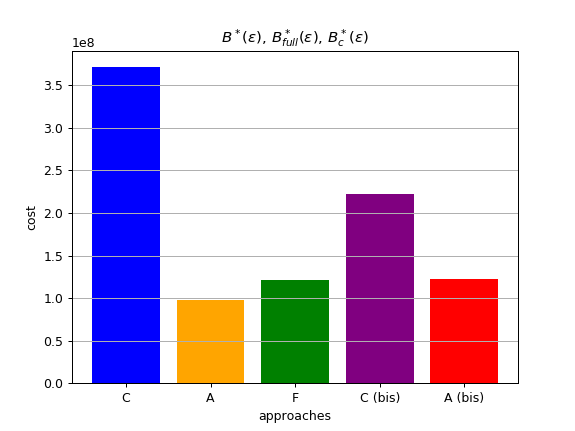

In [67]:
height = [best_constant,best_adaptive,full,best_constant2,best_adaptive2]
bars = ('C', 'A', 'F', 'C (bis)', 'A (bis)')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=['blue', 'orange', 'green', 'purple', 'red'])
plt.xticks(y_pos, bars)
plt.title('$B^*(\epsilon)$, $B^*_{full}(\epsilon)$, $B^*_c(\epsilon)$')
plt.ylabel('cost')
plt.xlabel('approaches')
plt.grid(axis='y')
plt.show()

### greedy for complex sets

## 2 : Stackelberg in game theory 

$Q$ will be the simplex set whereas $U$ will denote a norm-ball

## 3 : Progressive gradient in large scale deterministic optimization

no restriction